In [1]:
def read_quijote(filepath, cosm, snapnum, axis, space):
    """
    Returns array with Halo positions in Mpc/h
    """
    #import numpy as np
    import readgadget
    import readfof
    import redshift_space_library as RSL

    #-----------
    # Read data from Quijote
    #-----------

    # get the name of the corresponding snapshot
    snapshot = '/home/federico/mnts/clemente/Proyectos/VPF_Quijote/data/quijote/Snapshots/%s/0/snapdir_%03d/snap_%03d'%(cosm,snapnum,snapnum)
    
    # read the redshift, boxsize, cosmology...etc in the header
    header   = readgadget.header(snapshot)
    BoxSize  = header.boxsize/1e3  #Mpc/h
    #Nall     = header.nall         #Total number of particles
    #Masses   = header.massarr*1e10 #Masses of the particles in Msun/h
    Omega_m  = header.omega_m      #value of Omega_m
    Omega_l  = header.omega_l      #value of Omega_l
    h        = header.hubble       #value of h
    redshift = header.redshift     #redshift of the snapshot
    Hubble   = 100.0*np.sqrt(Omega_m*(1.0+redshift)**3+Omega_l) #Value of H(z) in km/s/(Mpc/h)

    print(f'BoxSize = {BoxSize} Mpc/h')
    print(f'Omega_m = {Omega_m}')
    print(f'h = {h}')
    print(f'redshift = {redshift:.1f}')


    FoF = readfof.FoF_catalog(filepath, snapnum, long_ids=False,
                            swap=False, SFR=False, read_IDs=False)
    pos_h  = FoF.GroupPos/1e3            #Halo positions in Mpc/h
    vel_h  = FoF.GroupVel*(1.0+redshift) #Halo peculiar velocities in km/s

    if space == 'zspace':
    	RSL.pos_redshift_space(pos_h, vel_h, BoxSize, Hubble, redshift, axis)

    return pos_h, vel_h, BoxSize  #Halo positions in Mpc/h

import numpy as np

dir = '/home/federico/mnts/clemente/Proyectos/VPF_Quijote/data/quijote/Halos/FoF/fiducial/0/'

gxs = read_quijote(dir,'fiducial',4,0,'zspace')

BoxSize = 1000.0 Mpc/h
Omega_m = 0.3175
h = 0.6711
redshift = 0.0


In [2]:
import treecorr

pos = gxs[0]
x = pos[:,0]
y = pos[:,1]
z = pos[:,2]

cat = treecorr.Catalog(x=x, y=y, z=z)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


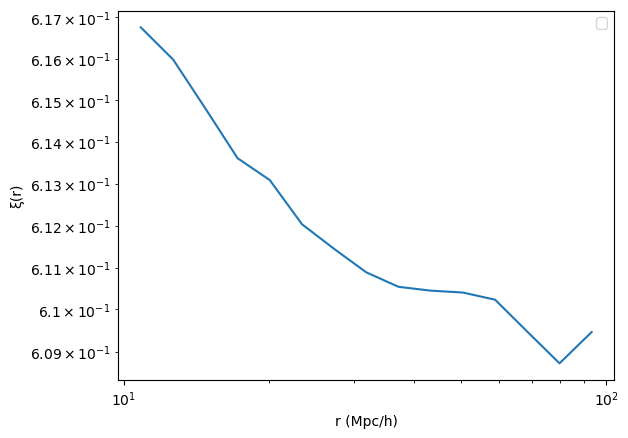

In [4]:
import matplotlib.pyplot as plt

# Step 3: Create a random catalog (same number of particles, uniformly distributed in the same volume)
# You can adjust the limits of the random distribution as per your data's range.
N = len(x)*10
rand_x = np.random.uniform(np.min(x), np.max(x), N)
rand_y = np.random.uniform(np.min(y), np.max(y), N)
rand_z = np.random.uniform(np.min(z), np.max(z), N)

# Step 4: Create TreeCorr Catalogs for the data and random catalogs
data_cat = treecorr.Catalog(x=x, y=y, z=z)
random_cat = treecorr.Catalog(x=rand_x, y=rand_y, z=rand_z)

# Step 5: Set up NNCorrelation objects to calculate DD, RR, and DR pair counts
nn_data = treecorr.NNCorrelation(min_sep=10, max_sep=100, nbins=15, metric='Euclidean')
nn_random = treecorr.NNCorrelation(min_sep=10, max_sep=100, nbins=15, metric='Euclidean')
nn_cross = treecorr.NNCorrelation(min_sep=10, max_sep=100, nbins=15, metric='Euclidean')

# Step 6: Compute the pair counts
nn_data.process(data_cat)        # DD counts
nn_random.process(random_cat)    # RR counts
nn_cross.process(data_cat, random_cat)  # DR counts

# Step 7: Calculate the Landy-Szalay estimator for ξ(r)
r = np.exp(nn_data.meanlogr)  # Separation distances (logarithmic binning)
DD = nn_data.npairs
RR = nn_random.npairs
DR = nn_cross.npairs
xi = (DD - 2 * DR + RR) / RR

# Step 8: Output and plot the results
plt.plot(r, xi)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('r (Mpc/h)')
plt.ylabel('ξ(r)')
plt.legend()
plt.show()